In [3]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

# ---------- Custom Dataset ---------- #
class SheepDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, class_to_idx=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = class_to_idx or {label: idx for idx, label in enumerate(sorted(dataframe['label'].unique()))}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['filename']
        label_name = row['label']
        label = self.class_to_idx[label_name]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# ---------- Load Data ---------- #
train_df = pd.read_csv(r"C:\Users\Manar\Desktop\Sheep Classification Images\train_split.csv")
val_df = pd.read_csv(r"C:\Users\Manar\Desktop\Sheep Classification Images\val_split.csv")
img_dir = r"C:\Users\Manar\Desktop\Sheep Classification Images\train"

class_names = sorted(train_df['label'].unique())
class_to_idx = {label: idx for idx, label in enumerate(class_names)}

# ---------- Transforms (No Augmentation) ---------- #
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
val_transform = train_transform

# ---------- Datasets and Loaders ---------- #
train_dataset = SheepDataset(train_df, img_dir, transform=train_transform, class_to_idx=class_to_idx)
val_dataset = SheepDataset(val_df, img_dir, transform=val_transform, class_to_idx=class_to_idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

# ---------- Model: ResNet50 ---------- #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

# ---------- Loss, Optimizer, Scheduler ---------- #
labels_array = train_df['label'].map(class_to_idx).values
class_weights = compute_class_weight('balanced', classes=np.unique(labels_array), y=labels_array)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# ---------- Evaluation Function ---------- #
def evaluate(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    f1 = f1_score(all_labels, all_preds, average='macro')
    acc = accuracy_score(all_labels, all_preds)
    return f1, acc

# ---------- Training Function ---------- #
def train_model(model, train_loader, val_loader, device, num_epochs=30):
    best_f1 = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        scheduler.step()
        epoch_loss = running_loss / len(train_loader.dataset)
        val_f1, val_acc = evaluate(model, val_loader, device)

        print(f"\n📊 Epoch [{epoch+1}/{num_epochs}]")
        print(f"Loss: {epoch_loss:.4f} | Val F1: {val_f1:.4f} | Val Acc: {val_acc:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), r"C:\Users\Manar\Desktop\Sheep Classification Images\resnet50_1best_model.pth")
            print("✅ Best model saved!")

# ---------- Run Training ---------- #
train_model(model, train_loader, val_loader, device, num_epochs=30)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Manar\\Desktop\\Sheep Classification Images\\train_split.csv'

In [2]:
import os
import torch
from torchvision import models, transforms
from PIL import Image
import pandas as pd

# ----- Settings ----- #
test_dir = r"C:\Users\Manar\Desktop\Sheep Classification Images\test"
model_path = r"C:\Users\Manar\Desktop\Sheep Classification Images\resnet50_best_model.pth"
output_csv = r"C:\Users\Manar\Desktop\Sheep Classification Images\resnet50_predictions.csv"

class_names = ['Barbari', 'Goat', 'Harri', 'Naeimi', 'Najdi', 'Roman', 'Sawakni']
idx_to_class = {i: c for i, c in enumerate(class_names)}

# ----- Preprocessing ----- #
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ----- Load Model ----- #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# ----- Predict on Test Images ----- #
results = []

for img_name in sorted(os.listdir(test_dir)):
    if img_name.endswith(('.jpg', '.png')):
        img_path = os.path.join(test_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image)
            _, pred = torch.max(output, 1)
            label = idx_to_class[pred.item()]
            results.append({'filename': img_name, 'label': label})

# ----- Save Predictions to CSV ----- #
df = pd.DataFrame(results)
df.to_csv(output_csv, index=False)
print(f"✅ Saved predictions to: {output_csv}")


C:\Users\Manar\AppData\Local\anaconda3\envs\sheepclass310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Manar\AppData\Local\anaconda3\envs\sheepclass310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Saved predictions to: C:\Users\Manar\Desktop\Sheep Classification Images\resnet50_predictions.csv


In [2]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate(model, dataloader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # حساب المقاييس
    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1_per_class = f1_score(all_labels, all_preds, average=None, zero_division=0)
    
    # طباعة النتائج النصية
    print(f"\nAccuracy: {acc:.4f}")
    print(f"Macro F1 Score: {f1_macro:.4f}")
    for i, class_name in enumerate(class_names):
        print(f"\n Class: {class_name}")
        print(f"Precision: {precision[i]:.4f}")
        print(f"Recall:    {recall[i]:.4f}")
        print(f"F1 Score:  {f1_per_class[i]:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Bar Plots (Precision, Recall, F1)
    metrics = ['Precision', 'Recall', 'F1 Score']
    values = [precision, recall, f1_per_class]
    for metric, vals in zip(metrics, values):
        plt.figure(figsize=(8, 4))
        sns.barplot(x=class_names, y=vals)
        plt.title(f"{metric} per Class")
        plt.ylim(0, 1)
        plt.ylabel(metric)
        plt.xlabel("Class")
        plt.tight_layout()
        plt.show()

    return f1_macro, acc



🔁 Fold 1/5


C:\Users\Manar\AppData\Local\anaconda3\envs\sheepclass310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Manar\AppData\Local\anaconda3\envs\sheepclass310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Epoch 1/5 - Loss: 1.5044
  Epoch 2/5 - Loss: 0.6005
  Epoch 3/5 - Loss: 0.2824
  Epoch 4/5 - Loss: 0.1438
  Epoch 5/5 - Loss: 0.0797

📊 Evaluation Metrics:
Accuracy: 0.9416
Macro F1 Score: 0.9241

Class: Barbari
  Precision: 0.7778
  Recall:    1.0000
  F1 Score:  0.8750

Class: Goat
  Precision: 0.9565
  Recall:    1.0000
  F1 Score:  0.9778

Class: Harri
  Precision: 1.0000
  Recall:    0.7692
  F1 Score:  0.8696

Class: Naeimi
  Precision: 0.9608
  Recall:    0.9608
  F1 Score:  0.9608

Class: Najdi
  Precision: 1.0000
  Recall:    1.0000
  F1 Score:  1.0000

Class: Roman
  Precision: 0.7857
  Recall:    0.7857
  F1 Score:  0.7857

Class: Sawakni
  Precision: 1.0000
  Recall:    1.0000
  F1 Score:  1.0000


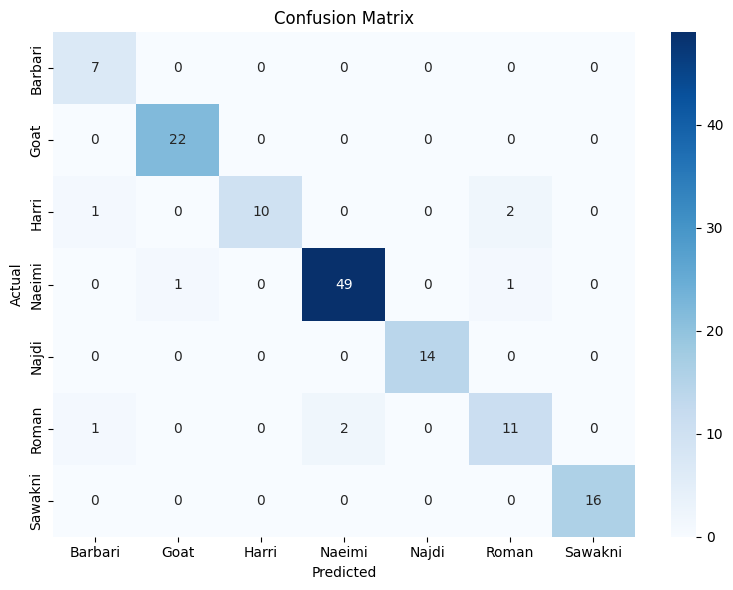

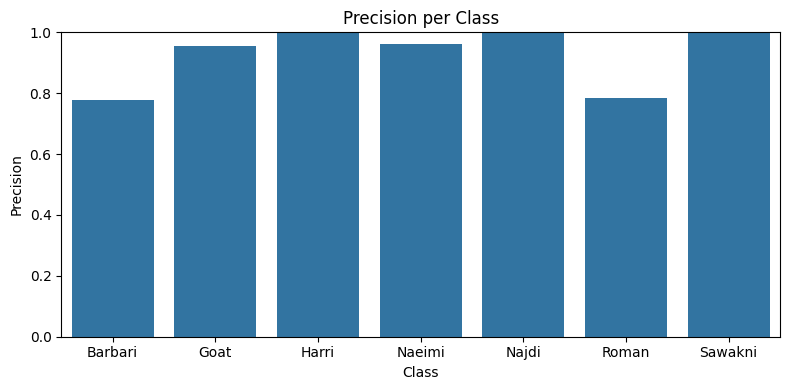

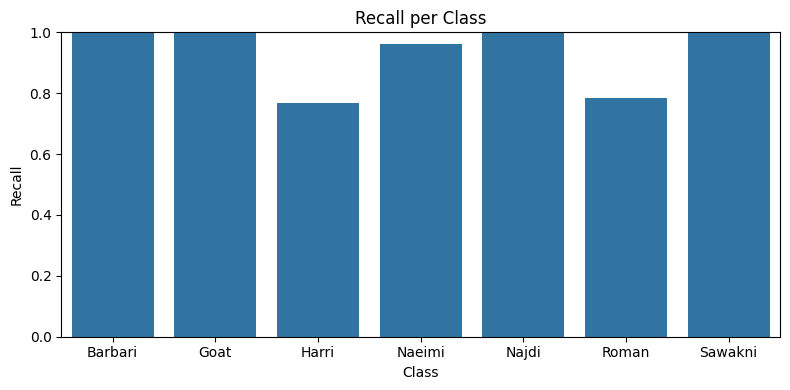

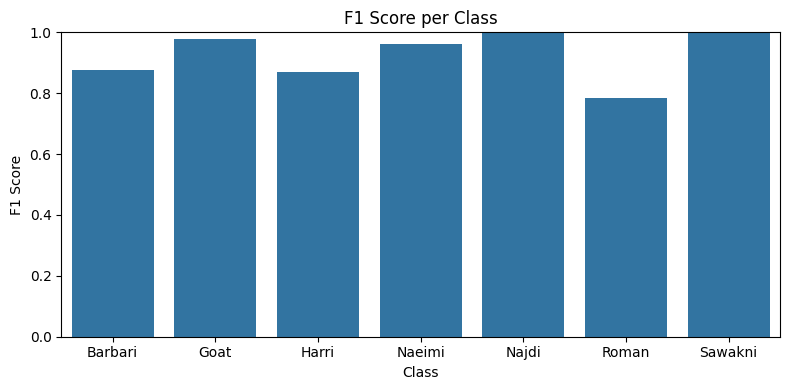


🔁 Fold 2/5


C:\Users\Manar\AppData\Local\anaconda3\envs\sheepclass310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Manar\AppData\Local\anaconda3\envs\sheepclass310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Epoch 1/5 - Loss: 1.5185
  Epoch 2/5 - Loss: 0.5923
  Epoch 3/5 - Loss: 0.2712
  Epoch 4/5 - Loss: 0.1219
  Epoch 5/5 - Loss: 0.0867

📊 Evaluation Metrics:
Accuracy: 0.9124
Macro F1 Score: 0.8840

Class: Barbari
  Precision: 0.6667
  Recall:    0.8571
  F1 Score:  0.7500

Class: Goat
  Precision: 1.0000
  Recall:    0.6818
  F1 Score:  0.8108

Class: Harri
  Precision: 0.8000
  Recall:    1.0000
  F1 Score:  0.8889

Class: Naeimi
  Precision: 0.9615
  Recall:    0.9804
  F1 Score:  0.9709

Class: Najdi
  Precision: 1.0000
  Recall:    1.0000
  F1 Score:  1.0000

Class: Roman
  Precision: 0.7500
  Recall:    0.8571
  F1 Score:  0.8000

Class: Sawakni
  Precision: 1.0000
  Recall:    0.9375
  F1 Score:  0.9677


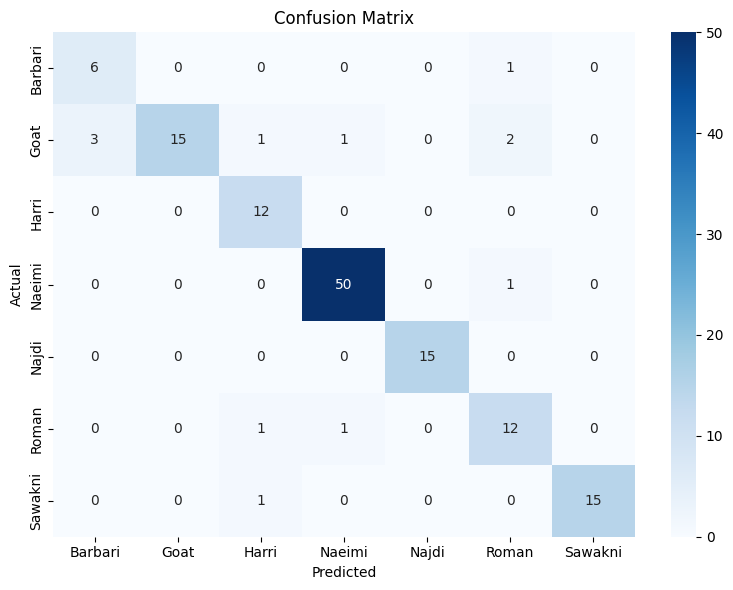

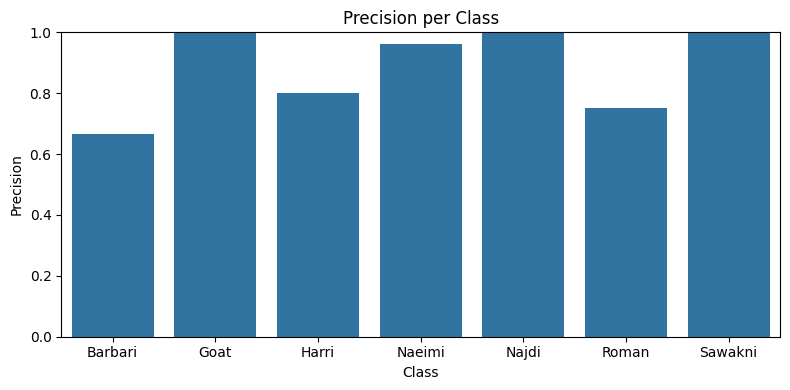

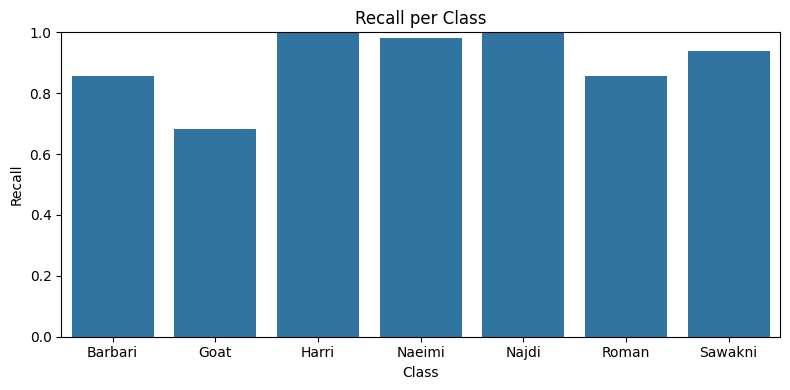

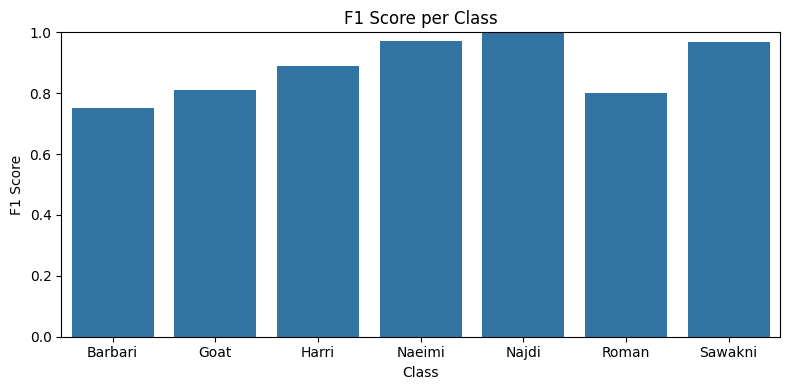


🔁 Fold 3/5


C:\Users\Manar\AppData\Local\anaconda3\envs\sheepclass310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Manar\AppData\Local\anaconda3\envs\sheepclass310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Epoch 1/5 - Loss: 1.4549
  Epoch 2/5 - Loss: 0.6200
  Epoch 3/5 - Loss: 0.2969
  Epoch 4/5 - Loss: 0.1474
  Epoch 5/5 - Loss: 0.0762

📊 Evaluation Metrics:
Accuracy: 0.9118
Macro F1 Score: 0.8926

Class: Barbari
  Precision: 0.8333
  Recall:    0.7143
  F1 Score:  0.7692

Class: Goat
  Precision: 0.7917
  Recall:    0.9048
  F1 Score:  0.8444

Class: Harri
  Precision: 0.9231
  Recall:    1.0000
  F1 Score:  0.9600

Class: Naeimi
  Precision: 0.9600
  Recall:    0.9412
  F1 Score:  0.9505

Class: Najdi
  Precision: 0.9286
  Recall:    0.9286
  F1 Score:  0.9286

Class: Roman
  Precision: 0.8571
  Recall:    0.8000
  F1 Score:  0.8276

Class: Sawakni
  Precision: 1.0000
  Recall:    0.9375
  F1 Score:  0.9677


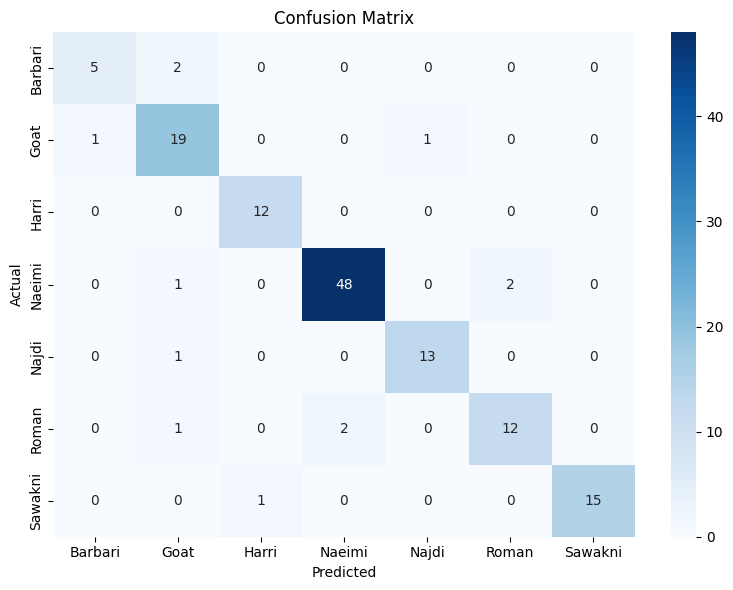

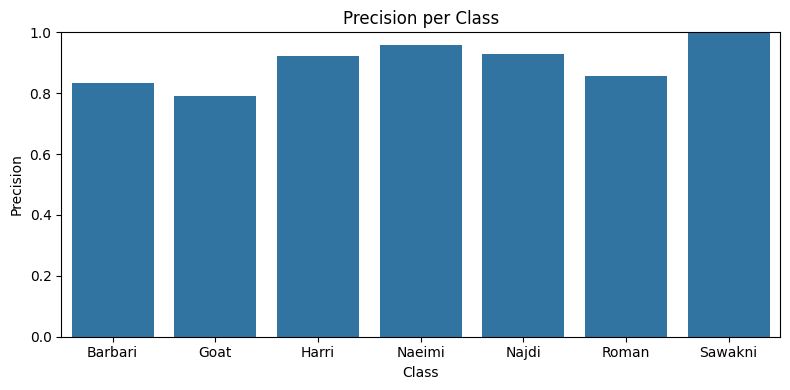

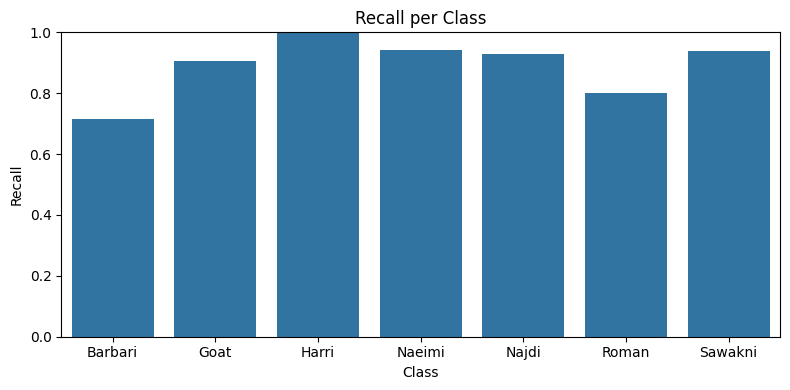

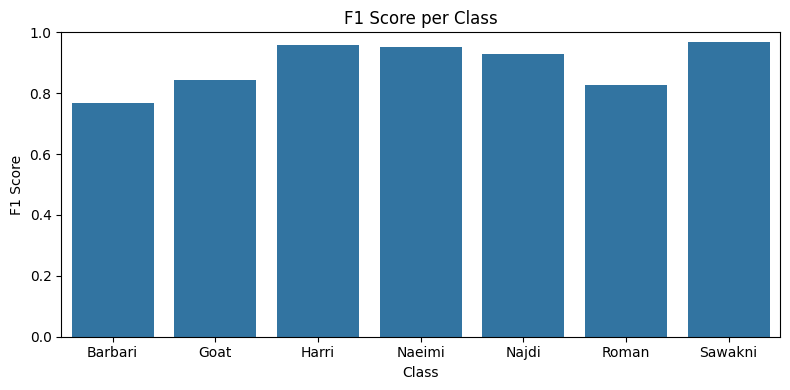


🔁 Fold 4/5


C:\Users\Manar\AppData\Local\anaconda3\envs\sheepclass310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Manar\AppData\Local\anaconda3\envs\sheepclass310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Epoch 1/5 - Loss: 1.5057
  Epoch 2/5 - Loss: 0.5960
  Epoch 3/5 - Loss: 0.2506
  Epoch 4/5 - Loss: 0.1317
  Epoch 5/5 - Loss: 0.0825

📊 Evaluation Metrics:
Accuracy: 0.9118
Macro F1 Score: 0.9076

Class: Barbari
  Precision: 1.0000
  Recall:    1.0000
  F1 Score:  1.0000

Class: Goat
  Precision: 0.9545
  Recall:    1.0000
  F1 Score:  0.9767

Class: Harri
  Precision: 0.8333
  Recall:    0.8333
  F1 Score:  0.8333

Class: Naeimi
  Precision: 0.9057
  Recall:    0.9412
  F1 Score:  0.9231

Class: Najdi
  Precision: 1.0000
  Recall:    0.9286
  F1 Score:  0.9630

Class: Roman
  Precision: 0.7143
  Recall:    0.6667
  F1 Score:  0.6897

Class: Sawakni
  Precision: 1.0000
  Recall:    0.9375
  F1 Score:  0.9677


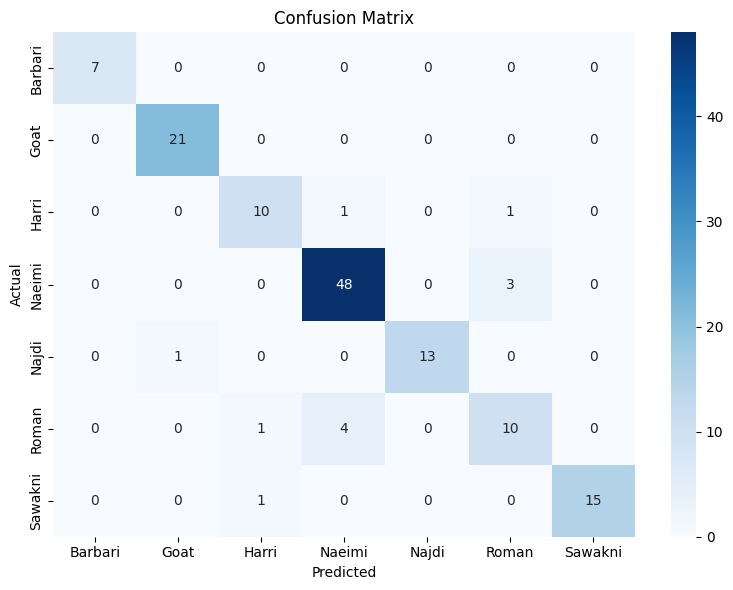

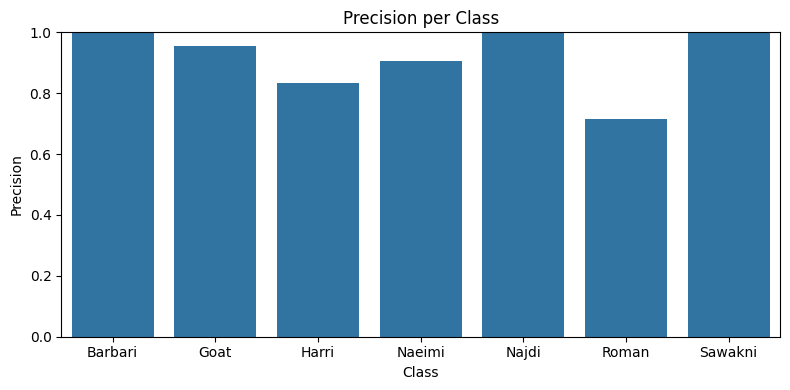

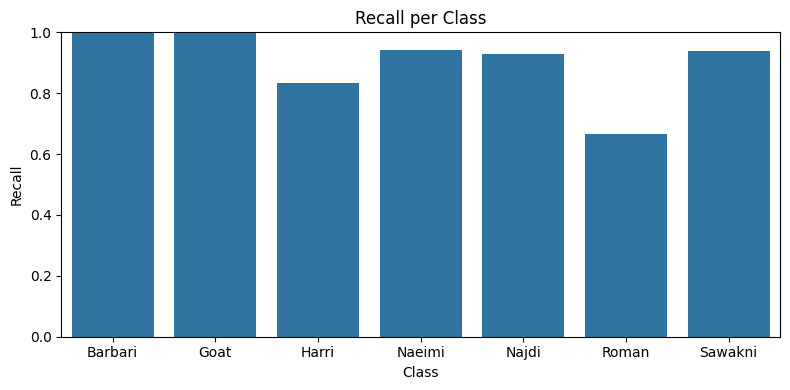

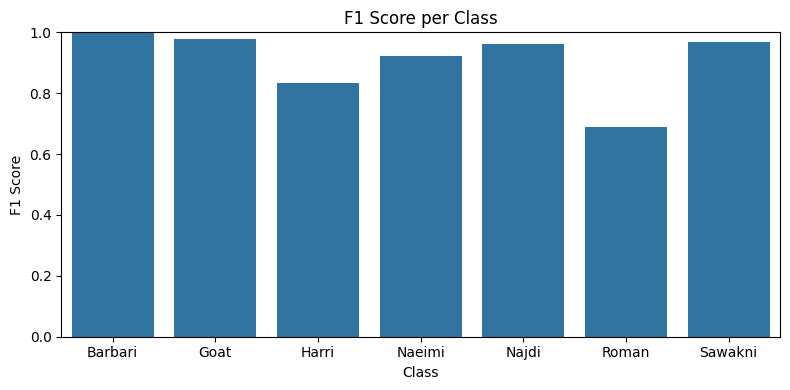


🔁 Fold 5/5


C:\Users\Manar\AppData\Local\anaconda3\envs\sheepclass310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Manar\AppData\Local\anaconda3\envs\sheepclass310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  Epoch 1/5 - Loss: 1.5138
  Epoch 2/5 - Loss: 0.6609
  Epoch 3/5 - Loss: 0.3172
  Epoch 4/5 - Loss: 0.1488
  Epoch 5/5 - Loss: 0.1061

📊 Evaluation Metrics:
Accuracy: 0.9779
Macro F1 Score: 0.9765

Class: Barbari
  Precision: 0.8750
  Recall:    1.0000
  F1 Score:  0.9333

Class: Goat
  Precision: 0.9524
  Recall:    0.9524
  F1 Score:  0.9524

Class: Harri
  Precision: 1.0000
  Recall:    1.0000
  F1 Score:  1.0000

Class: Naeimi
  Precision: 1.0000
  Recall:    0.9608
  F1 Score:  0.9800

Class: Najdi
  Precision: 1.0000
  Recall:    1.0000
  F1 Score:  1.0000

Class: Roman
  Precision: 1.0000
  Recall:    1.0000
  F1 Score:  1.0000

Class: Sawakni
  Precision: 0.9412
  Recall:    1.0000
  F1 Score:  0.9697


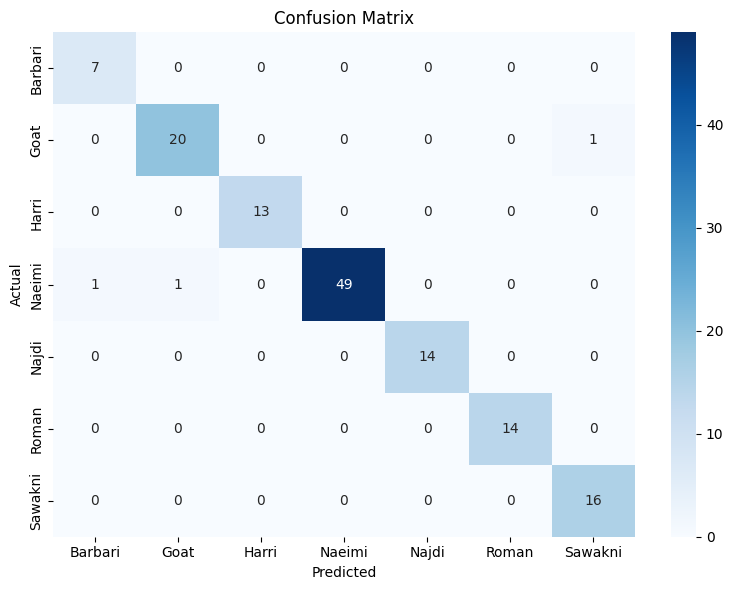

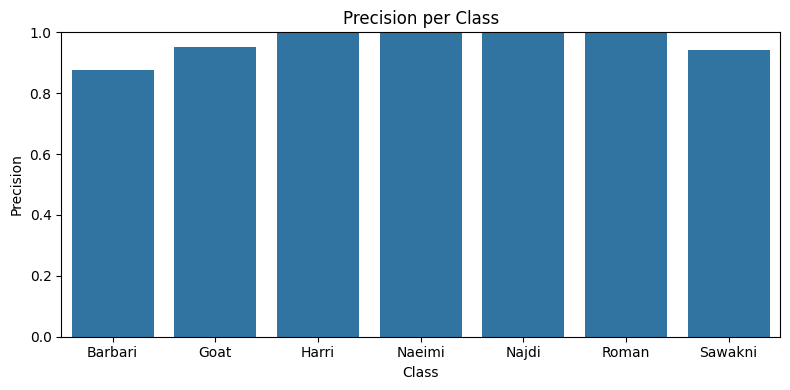

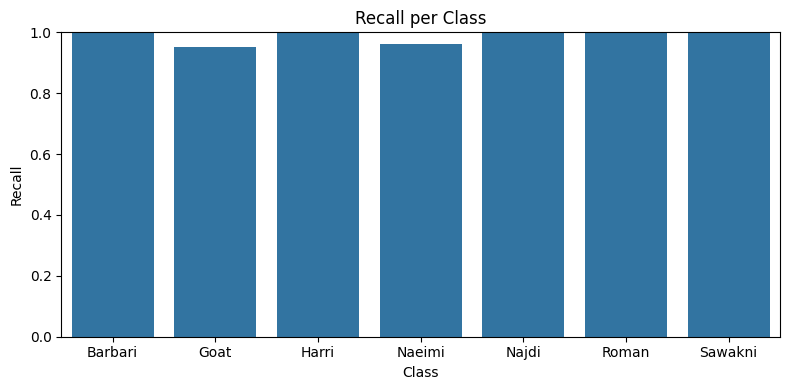

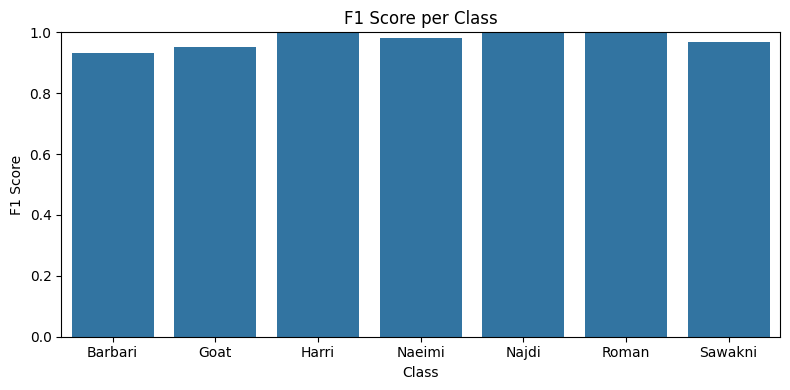


✅ Average F1 across folds: 0.9170
✅ Average Accuracy across folds: 0.9311


In [6]:

import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

# --------- Dataset Class ---------
class SheepDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, class_to_idx=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = class_to_idx or {label: idx for idx, label in enumerate(sorted(dataframe['label'].unique()))}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['filename']
        label = self.class_to_idx[row['label']]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# --------- Evaluation Function ---------
def evaluate(model, dataloader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1_per_class = f1_score(all_labels, all_preds, average=None, zero_division=0)

    print(f"\n Evaluation Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1 Score: {f1_macro:.4f}")
    for i, cls in enumerate(class_names):
        print(f"\nClass: {cls}")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall:    {recall[i]:.4f}")
        print(f"  F1 Score:  {f1_per_class[i]:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Bar charts
    for name, values in zip(['Precision', 'Recall', 'F1 Score'], [precision, recall, f1_per_class]):
        plt.figure(figsize=(8, 4))
        sns.barplot(x=class_names, y=values)
        plt.title(f"{name} per Class")
        plt.ylim(0, 1)
        plt.ylabel(name)
        plt.xlabel("Class")
        plt.tight_layout()
        plt.show()

    return f1_macro, acc

# --------- Paths ---------
train_csv_path = r"C:\Users\Manar\Desktop\Sheep Classification Images\train_labels.csv"
img_dir = r"C:\Users\Manar\Desktop\Sheep Classification Images\train"

# --------- Load Data ---------
train_df = pd.read_csv(train_csv_path)
class_names = sorted(train_df['label'].unique())
class_to_idx = {label: idx for idx, label in enumerate(class_names)}
train_df['label_idx'] = train_df['label'].map(class_to_idx)

# --------- Transforms ---------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# --------- Full Dataset ---------
full_dataset = SheepDataset(train_df, img_dir, transform=transform, class_to_idx=class_to_idx)

# --------- Cross Validation ---------
num_folds = 5
batch_size = 16
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df['filename'], train_df['label_idx'])):
    print(f"\n🔁 Fold {fold + 1}/{num_folds}")

    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, len(class_names))
    model = model.to(device)

    labels_array = train_df.iloc[train_idx]['label_idx'].values
    class_weights = compute_class_weight('balanced', classes=np.unique(labels_array), y=labels_array)
    weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        avg_loss = running_loss / len(train_loader.dataset)
        print(f"  Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

    f1, acc = evaluate(model, val_loader, device, class_names)
    fold_results.append((f1, acc))

avg_f1 = np.mean([f[0] for f in fold_results])
avg_acc = np.mean([f[1] for f in fold_results])
print(f"\n Average F1 across folds: {avg_f1:.4f}")
print(f" Average Accuracy across folds: {avg_acc:.4f}")


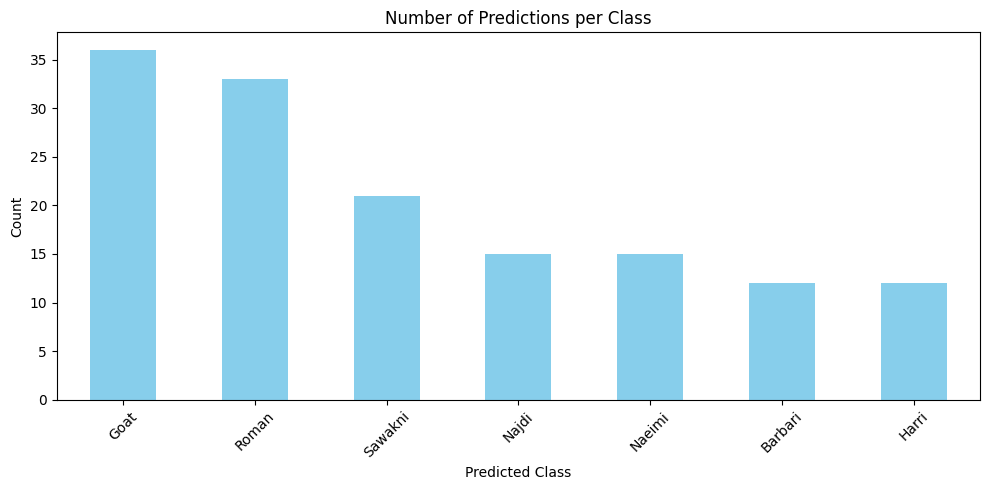

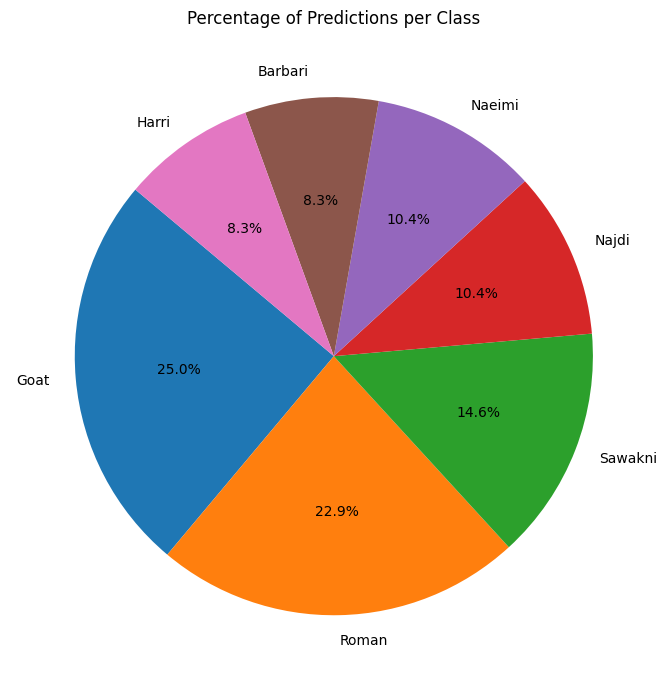


--- Prediction Distribution Summary ---

         Count  Percentage
label                     
Goat        36       25.00
Roman       33       22.92
Sawakni     21       14.58
Najdi       15       10.42
Naeimi      15       10.42
Barbari     12        8.33
Harri       12        8.33


In [7]:
import pandas as pd
import matplotlib.pyplot as plt


predictions_df = pd.read_csv(r"C:\Users\Manar\Downloads\resnet50_predictions.csv")


class_counts = predictions_df['label'].value_counts().sort_values(ascending=False)


class_percentages = (class_counts / class_counts.sum()) * 100


plt.figure(figsize=(10, 5))
class_counts.plot(kind='bar', color='skyblue')
plt.title("Number of Predictions per Class")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(7, 7))
plt.pie(class_percentages, labels=class_percentages.index, autopct='%1.1f%%', startangle=140)
plt.title("Percentage of Predictions per Class")
plt.tight_layout()
plt.show()


class_summary = pd.DataFrame({
    'Count': class_counts,
    'Percentage': class_percentages.round(2)
})

print("\n--- Prediction Distribution Summary ---\n")
print(class_summary)
